# Topic Modeling

In this notebook we analyze our corpus through **topic modelling**, a text analysis method that allows us to identify the topics within the texts. The main tool we have used is the [**Little MALLET Wrapper**](https://github.com/maria-antoniak/little-mallet-wrapper), a Python wrapper for [MALLET](http://mallet.cs.umass.edu/topics.php). Mallet is a software, originally developed in Java, that topic models texts using **[Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)** (**LDA**), a generative probabilistic model able to discover topics (i.e. set of words that, taken together, suggest a shared theme), and then automatically classify any individual document within the collection in terms of how "relevant" it is to each of the discovered topics. 

## Setup

  
Working in this Jupyter notebook requires having Java Development Kit and MALLET pre-installed. For set up instructions, we followed [Melanie Walsh's tutorial](http://melaniewalsh.github.io/Intro-Cultural-Analytics/Text-Analysis/Topic-Modeling-Set-Up.html).

Once Java and MALLET are installed, we need to setup Little MALLET Wrapper and import some libraries: 

In [1]:
#specify the path to the Java-based MALLET software
path_to_mallet = 'C:/mallet-2.0.8/bin/mallet'

#install the Little MALLET Wrapper and the data visualization library Seaborn
'''
!pip install little_mallet_wrapper
!pip install seaborn
'''

#import the above packages and libraries for working with files and the file system
import little_mallet_wrapper
import seaborn
import glob
from pathlib import Path

## Get Training Data From Text Files

Before we topic model the Gobby Kid project corpus, we need to process the text files and prepare them for analysis.

In [2]:
#assign to the "directory" variable the path to the directory containing our documents
m_directory = "C:/Users/media/Desktop/gobbykid/balanced_corpus/m"
f_directory = "C:/Users/media/Desktop/gobbykid/balanced_corpus/f"

#use `glob.gob()` function to make a list of all the `.txt` files in that directory.
m_files = glob.glob(f"{m_directory}/*.txt")
f_files = glob.glob(f"{f_directory}/*.txt")

In [3]:
#print(f"Male corpus: \n", m_files)
#print(f"Female corpus: \n", f_files)

## Process Texts and files

Next we process our texts with the function `little_mallet_wrapper.process_string()`, which takes every individual text file, transform all the text to lowercase, removes stopwords, punctuation, and numbers. We add the processed text to our master list `training_data`, i.e. the data we will use to train our LDA topic model.

#### Stop words
The default list of stop words in `little_mallet_wrapper` is quite limited. We want to extend it in order to get **more meaningful words** in our topics, i.e. we want to leave out of our model not only grammatical words, but also extremely common words like "said" or "think". Moreover, we expect characters' names to be highly weighting in the training phase, but not particularly relevant to get an overview of the common themes in the dataset: we want to exclude from the results also the characters' names we have previously extracted.

In [4]:
#import LMW stop words list (stored in the variable "STOPS"), in order to extend it
from little_mallet_wrapper.little_mallet_wrapper import STOPS as lmw_stopwords #!important: import from little_mallet_wrapper.little_mallet_wrapper, otherwise it will look for STOPS inside __init__.py (inside little_mallet_wrapper) and it will not find it!

#print("Default stop words in lmw: ", lmw_stopwords)


##### Most common words
First, let's calculate the most common words in our corpus. We will tokenize the texts at word level and join all their words in one list; then we'll extract the **frequency distribution** of each word in the dataset using `nltk`.
Finally, we can examine manually if, amongst the most common ones, there is any word we don't want to be included in our model. 

In [5]:
"""


import nltk
from tqdm import tqdm
dataset_words = [] #initialize a list to contain all the words in the whole dataset
for file in tqdm(m_files + f_files): #tqdm just displays a progress bar
    file_text = open(file, encoding='utf-8').read()
    file_words = nltk.tokenize.word_tokenize(file_text) #texts are segmented in words
    dataset_words.extend(file_words) 
    
allWordDist = nltk.FreqDist(w.lower() for w in dataset_words) #frequency ditribution of each word in the dataset (FreqDist object) 

k = 400 #set k to the number of words you want retrieved from the frequency distribution
most_common_words = [item[0] for item in allWordDist.most_common(k)] #create a list with all the k most common words in the whole corpus. allWordDist.most_common() returns a list of tuples of the form: ("word", frequency)

#print(f"These are the {k} most frequent words: ", most_common_words)


"""

'\n\n\nimport nltk\nfrom tqdm import tqdm\ndataset_words = [] #initialize a list to contain all the words in the whole dataset\nfor file in tqdm(m_files + f_files): #tqdm just displays a progress bar\n    file_text = open(file, encoding=\'utf-8\').read()\n    file_words = nltk.tokenize.word_tokenize(file_text) #texts are segmented in words\n    dataset_words.extend(file_words) \n    \nallWordDist = nltk.FreqDist(w.lower() for w in dataset_words) #frequency ditribution of each word in the dataset (FreqDist object) \n\nk = 400 #set k to the number of words you want retrieved from the frequency distribution\nmost_common_words = [item[0] for item in allWordDist.most_common(k)] #create a list with all the k most common words in the whole corpus. allWordDist.most_common() returns a list of tuples of the form: ("word", frequency)\n\n#print(f"These are the {k} most frequent words: ", most_common_words)\n\n\n'

After a manual analysis of the most common words, we decide to add some of them to the stop words list, particularly the ones carrying "less meaning", such as words representing *basic* actions which might be very common in the narration (such as "went" or "came"), or related to the presence of dialogues (e.g. "said", "called", "asked"...). 

Then, we add to the words to ignore the characters' names we [previously extracted](#link alla sezione della NER).

<p align="center" style="color:red; font-weight:bold">
Qui sotto importo il file in cui è salvata una LISTA contenente tutti i nomi COMPLETI dei personaggi (entrambi i corpora insieme). Questi nomi vengono poi processati più sotto da `get_characters_names`, che li divide e crea una nuova lista, `characters_names`, che contiene i nomi completi ma anche le singole parti (es. solo nome o solo cognome). <u>Se possibile, questa parte sarebbe meglio modificarla, alla fine,</u> per fare in modo che non si ripetano passaggi che il codice di Tommaso eventualmente fa già,  o in ogni caso per non ricorrere ad altri file esterni al jupyter notebook unico. Cioè quando avremo messo tutto quanto su un unico jupyter notebook, è il caso che modifichiamo la parte qui sotto e introduciamo i seguenti passaggi:
* richiamiamo direttamente la variabile in cui è salvato l'output delle funzioni che ha fatto Tommaso per estrarre le NER, e la trasformiamo in una *unica* lista con tutti i nomi dei personaggi, da entrambi i corpora indivisi
* passiamo questa lista in input a `get_characters_names`, che divide le stringhe
* aggiungiamo la lista output di `get_characters_names` alla lista di stopwords per il pre-processing
</p>

In [6]:
#if the list is formatted as a list in a .txt file you can use the code below
"""
import pickle

with open('C:/Users/media/Desktop/gobbykid/tm/all_characters_file.txt', 'rb') as f:  #change the path to the location where the result of run.py is stored
    retrieved_characters = pickle.load(f) #retrieves the variable from the specified file, in which all the characters' FULL names are stored in a list
"""

"\nimport pickle\n\nwith open('C:/Users/media/Desktop/gobbykid/tm/all_characters_file.txt', 'rb') as f:  #change the path to the location where the result of run.py is stored\n    retrieved_characters = pickle.load(f) #retrieves the variable from the specified file, in which all the characters' FULL names are stored in a list\n"

In [7]:
import csv
import ast
csv_path = "C:/Users/media/Desktop/gobbykid/gobbykid-characters-extraction/characters_extraction_and_gender_recognition/characters.csv"

retrieved_characters =[]
with open(csv_path, 'r', encoding='utf-8') as csv_file:
        csv_reader = csv.DictReader(csv_file, delimiter=',')
        for row in csv_reader:
                retrieved_characters.extend(ast.literal_eval(row["male_characters_names"]) + ast.literal_eval(row["female_characters_names"]) + ast.literal_eval(row['unknown_gender_names']))

In [8]:
def get_characters_names (characters_list):
    # empty honorifics list if you don't want to include in the model character-related words
    honorifics = []
    #honorifics = ["mr","master","mrs","miss","lady","sir","dame","lord","sister","mother","aunt","uncle","doctor","captain","father","count","professor","major","little","big","old","king","don","dr","queen","boy","girl","green","black","grey","gray","golden","silver","blue", "long"]
    output_set = set()
    #add to the previous list also the first names and last names taken by themselves (eg both "john smith" and "john" get in the list), excluding all the words in "honorifics"
    

    for item in characters_list:
        if " " in item:
            minilist = item.split()
            for w in minilist:
                if w not in honorifics:
                    output_set.add(w)
        else:
            output_set.add(item)
    
    output_list = sorted(output_set) #convert the set to a list
    return output_list

In [9]:
custom_stopwords = lmw_stopwords #initialize final list of custom stop words as containing the default stop words of lmw

more_stopwords = ["one","two","ones","say","says","said","think","thinks","thought","thing","things","go","goes","went","come","comes","came","coming","much","get","gets","got","ask","asks","asked","didn","would","could","three","other","another","until","till","upon","shall","make","made","might","must","going","way", "thou", "thee", "seems", "seem", "seemed", "never", "tell", "told", "tells", "wouldn", "tha", "like", "however","let","rather","yes", "no","little", "old", "well", "always", "never", "time", "long", "see", "saw", "sees"]

# list of gender-related words to remove
gendered_stopwords = ['guy','dr','spokesman','chairman',"men's",'men','boy',
'boys','brother','brothers','dad','dads','dude','father',
'fathers','gentleman','gentlemen','god','grandfather','grandpa',
'grandson','groom','he','himself','his','husband','pastor','husbands','king','male','man',
'mr','nephew','nephews','priest','prince','son','sons','uncle','uncles',
'waiter','widower','widowers','lord','master',"mrs","miss","lady","sir","dame","lord","sister","mother","aunt","uncle","doctor","father","count","professor", 'heroine','drss','spokeswoman','chairwoman',"women's",'actress','women',"she's",'her','aunt','aunts','bride','daughter','daughters','female','fiancee','girl',
'girls','goddess','granddaughter','grandma','grandmother',
'herself','ladies','lady','mom','moms','mother','mothers','mrs','ms','niece',
'nieces','priestess','princess','queens','sister','sisters','waitress',
'widow','widows','wife','wives','woman','lady','mistress','queen']

characters_names = get_characters_names(retrieved_characters) #the function returns a list of strings that are (part of) a character's name

custom_stopwords.extend(more_stopwords)
custom_stopwords.extend(characters_names)
#removes words like "mr", "mrs", "mother", "father", etc.
custom_stopwords.extend(gendered_stopwords) 

#### Pre-process
Now that the custom stop words list is ready, we can finally pre-process our documents.

In [10]:


from tqdm import tqdm
#initialize training_data as empty
from encodings.utf_8 import decode


m_training_data = []
f_training_data = []

#process each file and add it to the training_data list
for file in tqdm(m_files):
    text = open(file, encoding='utf-8').read() 
    processed_text = little_mallet_wrapper.process_string(text, numbers='remove', stop_words=custom_stopwords, remove_stop_words=True, stop_words_extra=custom_stopwords)
    m_training_data.append(processed_text)

for file in tqdm(f_files):
    text = open(file, encoding='utf-8').read()
    processed_text = little_mallet_wrapper.process_string(text, numbers='remove', stop_words=custom_stopwords, remove_stop_words=True, stop_words_extra=custom_stopwords)
    f_training_data.append(processed_text)



100%|██████████| 157/157 [20:51<00:00,  7.97s/it]


Given that processing the texts is a time-consuming operation and we might want to train our model several times in order to chose the best parameters, we can optionally store the output of the text processing in files of choice, so as to be able to retrieve the ready-to-use texts directly, i.e. skipping the processing phase, the next time we use this program.

In [11]:

# stores processed texts in specific files

#MALE CORPUS
m_pointer = 0
for processed_book in m_training_data:
    booktitle= Path(m_files[m_pointer]).stem
    with open(f"m_preprocess/Processed_{booktitle}.txt", 'w') as f:
        f.write(processed_book)
        m_pointer+=1


#FEMALE CORPUS
f_pointer = 0
for processed_book in f_training_data:
    booktitle= Path(f_files[f_pointer]).stem
    with open(f"f_preprocess/Processed_{booktitle}.txt", 'w') as f:
        f.write(processed_book)
        f_pointer+=1

"""

#re-create the training data variable from saved files

#MALE CORPUS
m_training_data = []
m_processed_files_paths = glob.glob("m_preprocess/*.txt") #creates a list with the file paths of the processed texts
for processed_text in m_processed_files_paths:
    ready_text = open(processed_text).read()
    m_training_data.append(ready_text)

#FEMALE CORPUS
f_training_data = []
f_processed_files_paths = glob.glob("f_preprocess/*.txt") #creates a list with the file paths of the processed texts
for processed_text in f_processed_files_paths:
    ready_text = open(processed_text).read()
    f_training_data.append(ready_text)


"""

'\n\n#re-create the training data variable from saved files\n\n#MALE CORPUS\nm_training_data = []\nm_processed_files_paths = glob.glob("m_preprocess/*.txt") #creates a list with the file paths of the processed texts\nfor processed_text in m_processed_files_paths:\n    ready_text = open(processed_text).read()\n    m_training_data.append(ready_text)\n\n#FEMALE CORPUS\nf_training_data = []\nf_processed_files_paths = glob.glob("f_preprocess/*.txt") #creates a list with the file paths of the processed texts\nfor processed_text in f_processed_files_paths:\n    ready_text = open(processed_text).read()\n    f_training_data.append(ready_text)\n\n\n'

We're also making a master list of the original text of the novels for future reference.

In [12]:
m_original_texts = []
for file in m_files:
    text = open(file, encoding='utf-8').read()
    m_original_texts.append(text)

f_original_texts = []
for file in f_files:
    text = open(file, encoding='utf-8').read()
    f_original_texts.append(text)

## Process Titles

We use the [`Path().stem`](https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.stem) function to extract just the last part of the file path without the ".txt" file extension, and save the file name (formatted as *year of publication* + *author's last name* + *book's title*) as title for each document.

In [13]:
m_book_titles = [Path(file).stem for file in m_files]
f_book_titles = [Path(file).stem for file in f_files]

In [14]:
#MALE CORPUS
m_book_titles

['1836_marryat-mr-midshipman-easy',
 '1841_marryat-masterman-ready',
 '1844_marryat-the-settlers-in-canada',
 '1845_dickens-the-cricket-on-the-hearth-a-fairy-tale-of-home',
 '1847_marryat-the-children-of-the-new-forest',
 '1848_marryat-the-little-savage',
 '1851_ruskin-the-king-of-the-golden-river',
 '1855_kingsley-westward-ho',
 '1856_ballantyne-the-young-fur-traders',
 '1857_ballantyne-the-coral-island-a-tale-of-the-pacific-ocean',
 '1857_hughes-tom-browns-school-days',
 '1858_ballantyne-martin-rattler',
 '1858_farrar-eric-or-little-by-little',
 '1861_hughes-tom-brown-at-oxford',
 '1862_farrar-st-winfreds-the-world-of-school',
 '1863_ballantyne-fighting-the-whales',
 '1863_kingsley-the-water-babies',
 '1865_ballantyne-the-lighthouse',
 '1865_carroll-alices-adventures-in-wonderland',
 '1869_dickens-david-copperfield',
 '1870_hemyng-jack-harkaways-boy-tinker-among-the-turks',
 '1871_carroll-through-the-looking-glass',
 '1871_macdonald-at-the-back-of-the-north-wind',
 '1871_macdonald-ra

In [15]:
#FEMALE CORPUS
f_book_titles

['1835_sherwood-shanty-the-blacksmith-a-tale-of-other-times',
 '1839_sinclair-holiday-house-a-series-of-tales',
 '1841_martineau-the-settlers-at-home',
 '1850_sherwood-the-young-lord-and-other-tales-to-which-is-added-victorine-durocher',
 '1851_hall-turns-of-fortune-and.other-tales',
 '1853_yonge-the-heir-of-redclyffe',
 '1854_yonge-the-little-duke-richard-the-fearless',
 '1855_yonge-the-lances-of-lynwood',
 '1856_yonge-the-daisy-chain-or-aspirations',
 '1857_browne-grannys-wonderful-chair',
 '1857_tucker-the-rambles-of-a-rat',
 '1858_tucker-flora',
 '1860_yonge-countess-kate',
 '1860_yonge-the-pigeon-pie',
 '1861_yonge-the-stokesley-secret',
 '1862_ewing-melchiors-dream-and-other-tales',
 '1863_tucker-the-crown-of-success',
 '1866_yonge-the-prince-and-the-page-a-story-of-the-last-crusade',
 '1867_stretton-jessicas-first-prayer-and-jessicas-mother',
 '1868_stretton-little-megs-children',
 '1869_ewing-mrs-overtheways-remembrances',
 '1869_ewing-the-land-of-lost-toys',
 '1869_stretton-al

## Get Training Data Stats

We can get training data summary statistics by using the function ```little_mallet_wrapper.print_dataset_stats()```.

In [16]:
print(f"----Male writers corpus statistics:")
little_mallet_wrapper.print_dataset_stats(m_training_data)

print(f"\n----Female writers corpus statistics:")
little_mallet_wrapper.print_dataset_stats(f_training_data)

----Male writers corpus statistics:
Number of Documents: 109
Mean Number of Words per Document: 25962.9
Vocabulary Size: 51882

----Female writers corpus statistics:
Number of Documents: 157
Mean Number of Words per Document: 16119.2
Vocabulary Size: 43449


## Training the Topic Model

We are going to train the model with the function [`quick_train_topic_model(path_to_mallet, output_directory_path, num_topics, training_data)`](https://github.com/maria-antoniak/little-mallet-wrapper#quick_train_topic_modelpath_to_mallet-output_directory_path-num_topics-training_data). First of all, then, we need to set the variables the function is taking as parameters.
The `path_to_mallet` and `training_data` variables have been already specified, we only need to create the `num_topics` and the `output_directory_path` variables. The latter specifies where Little MALLET Wrapper will find and output all the results of our topic modelling.

In [17]:
#specify the number of topics we want returned
num_topics = 7

#set desired output directory/ies (will be created inside current directory)
m_output_directory_path = 'topic-model-output/m_results'#MALE CORPUS
f_output_directory_path = 'topic-model-output/f_results'#FEMALE CORPUS


#set topic model output files! No need to change anything below here
#MALE CORPUS
Path(f"{m_output_directory_path}").mkdir(parents=True, exist_ok=True)

m_path_to_training_data           = f"{m_output_directory_path}/training.txt"
m_path_to_formatted_training_data = f"{m_output_directory_path}/mallet.training"
m_path_to_model                   = f"{m_output_directory_path}/mallet.model.{str(num_topics)}"
m_path_to_topic_keys              = f"{m_output_directory_path}/mallet.topic_keys.{str(num_topics)}"
m_path_to_topic_distributions     = f"{m_output_directory_path}/mallet.topic_distributions.{str(num_topics)}"

#FEMALE CORPUS
Path(f"{f_output_directory_path}").mkdir(parents=True, exist_ok=True)

f_path_to_training_data           = f"{f_output_directory_path}/training.txt"
f_path_to_formatted_training_data = f"{f_output_directory_path}/mallet.training"
f_path_to_model                   = f"{f_output_directory_path}/mallet.model.{str(num_topics)}"
f_path_to_topic_keys              = f"{f_output_directory_path}/mallet.topic_keys.{str(num_topics)}"
f_path_to_topic_distributions     = f"{f_output_directory_path}/mallet.topic_distributions.{str(num_topics)}"

### Train Topic Model

Then we're going to train our topic model with `little_mallet_wrapper.quick_train_topic_model()`. 

In [18]:
#MALE CORPUS
little_mallet_wrapper.quick_train_topic_model(path_to_mallet,
                                             m_output_directory_path,
                                             num_topics,
                                             m_training_data)

#FEMALE CORPUS
little_mallet_wrapper.quick_train_topic_model(path_to_mallet,
                                             f_output_directory_path,
                                             num_topics,
                                             f_training_data)

Importing data...
Complete
Training topic model...
Complete
Importing data...
Complete
Training topic model...
Complete


([['yet',
   'though',
   'house',
   'face',
   'many',
   'even',
   'day',
   'know',
   'whilst',
   'life',
   'forth',
   'days',
   'knew',
   'moment',
   'within',
   'heart',
   'spoke',
   'fear',
   'answered',
   'back'],
  ['put',
   'cried',
   'house',
   'illustration',
   'back',
   'garden',
   'day',
   'took',
   'work',
   'quite',
   'children',
   'many',
   'every',
   'used',
   'look',
   'enough',
   'also',
   'called',
   'behind',
   'sat'],
  ['know',
   'though',
   'better',
   'first',
   'without',
   'mind',
   'dear',
   'last',
   'even',
   'nothing',
   'wish',
   'every',
   'indeed',
   'believe',
   'anything',
   'right',
   'less',
   'yet',
   'ever',
   'letter'],
  ['dear',
   'know',
   'room',
   'quite',
   'want',
   'school',
   'house',
   'course',
   'back',
   'won',
   'day',
   'really',
   'face',
   'moment',
   'put',
   'take',
   'sort',
   'give',
   'mean',
   'look'],
  ['away',
   'face',
   'child',
   'day',
   'bac

## Display Topics and Top Words

To examine the `num_topics` topics that the topic model extracted from our corpus we use the [`little_mallet_wrapper.load_topic_keys()`](https://github.com/maria-antoniak/little-mallet-wrapper#load_topic_keystopic_keys_path) function, reading and processing the output from the file in input.

In [19]:
#MALE CORPUS
m_topics = little_mallet_wrapper.load_topic_keys(m_path_to_topic_keys) #list of lists of strings
print(f"\n------------ ♂️ MALE CORPUS ------------\n")
for topic_number, topic in enumerate(m_topics):
    print(f"Topic: {topic_number}\n\n{topic}\n")

#FEMALE CORPUS
f_topics = little_mallet_wrapper.load_topic_keys(f_path_to_topic_keys) #list of lists of strings
print(f"\n\n------------ ♀️ FEMALE CORPUS ------------\n")
for topic_number, topic in enumerate(f_topics):
    print(f"Topic: {topic_number}\n\n{topic}\n")


------------ ♂️ MALE CORPUS ------------

Topic: 0

['friend', 'exclaimed', 'returned', 'among', 'moment', 'thus', 'small', 'quite', 'also', 'many', 'became', 'day', 'friends', 'replied', 'first', 'almost', 'continued', 'surprise', 'found', 'river']

Topic: 1

['yet', 'enough', 'day', 'back', 'last', 'even', 'night', 'life', 'stood', 'among', 'face', 'cried', 'knew', 'heart', 'word', 'many', 'every', 'still', 'fell', 'days']

Topic: 2

['know', 'away', 'night', 'nothing', 'house', 'back', 'first', 'looked', 'dear', 'door', 'ever', 'face', 'took', 'quite', 'take', 'day', 'better', 'room', 'without', 'put']

Topic: 3

['back', 'cried', 'away', 'look', 'right', 'side', 'began', 'looked', 'feet', 'along', 'put', 'trees', 'fish', 'half', 'know', 'ran', 'behind', 'though', 'left', 'day']

Topic: 4

['know', 'school', 'last', 'day', 'half', 'back', 'fellow', 'room', 'house', 'right', 'look', 'first', 'new', 'take', 'put', 'mind', 'fellows', 'every', 'better', 'done']

Topic: 5

['deck', 'awa

## Load Topic Distributions

MALLET also calculates the probability distribution of these topics over every single document in the corpus, that is, the probability that each topic exists in a specified document. Therefore, we can use these probability distributions to examine how strongly the extracted topics are associated with a given document (book) in our corpus.

To get the topic distributions, we're going to use the [`little_mallet_wrapper.load_topic_distributions()`](https://github.com/maria-antoniak/little-mallet-wrapper#load_topic_distributionstopic_distributions_path) function, which will read and process the MALLET topic model output (contained in the file whose path is stored in the `path_to_topic_distributions` variable) and return a list of the probability distributions of each topic over each document.

In [20]:
#store the probability distributions (list of lists) in a variable
m_topic_distributions = little_mallet_wrapper.load_topic_distributions(m_path_to_topic_distributions) #list of lists of integers
f_topic_distributions = little_mallet_wrapper.load_topic_distributions(f_path_to_topic_distributions) #list of lists of integers

Of course, we can analyze the probability distribution of the topics extracted from a specific dataset over one specific book.

In [21]:
#specify the title/label of the desidered document in a variable
book_to_check = "1882_delaramee-bimbi"
#get document's index in the list and store it in a variable
book_number = f_book_titles.index(book_to_check)
#specify the set of topics - i.e. extracted from male/female corpus - (and relative topic distributions) for which you want to get the probability distribution over the input book 
topics_lol = f_topics
topic_distribution_lol = f_topic_distributions

#calculate the probability distribution of the female/male corpus topics over the input book
print(f"Topic Distributions for {f_book_titles[book_number]}\n")
for topic_number, (topic, topic_distribution) in enumerate(zip(topics_lol, topic_distribution_lol[book_number])):
    print(f"Topic {topic_number} {topic} \nProbability: {round(topic_distribution, 3)}\n")

#---------------------------------------------------



Topic Distributions for 1882_delaramee-bimbi

Topic 0 ['yet', 'though', 'house', 'face', 'many', 'even', 'day', 'know', 'whilst', 'life', 'forth', 'days', 'knew', 'moment', 'within', 'heart', 'spoke', 'fear', 'answered', 'back'] 
Probability: 0.125

Topic 1 ['put', 'cried', 'house', 'illustration', 'back', 'garden', 'day', 'took', 'work', 'quite', 'children', 'many', 'every', 'used', 'look', 'enough', 'also', 'called', 'behind', 'sat'] 
Probability: 0.285

Topic 2 ['know', 'though', 'better', 'first', 'without', 'mind', 'dear', 'last', 'even', 'nothing', 'wish', 'every', 'indeed', 'believe', 'anything', 'right', 'less', 'yet', 'ever', 'letter'] 
Probability: 0.066

Topic 3 ['dear', 'know', 'room', 'quite', 'want', 'school', 'house', 'course', 'back', 'won', 'day', 'really', 'face', 'moment', 'put', 'take', 'sort', 'give', 'mean', 'look'] 
Probability: 0.012

Topic 4 ['away', 'face', 'child', 'day', 'back', 'night', 'looked', 'heart', 'children', 'many', 'last', 'still', 'look', 'take',

## Explore Heatmap of Topics and Texts

We can visualize and compare these topic probability distributions with a heatmap by using the [`little_mallet_wrapper.plot_categories_by_topics_heatmap()`](https://github.com/maria-antoniak/little-mallet-wrapper#plot_categories_by_topics_heatmaplabels-topic_distributions-topic_keys-output_pathnone-target_labelsnone-dimnone) function.

First, we only need to specify the `target_labels` parameter, telling the function which documents we'd like to be plotted in the graph. **Below, we are plotting *some* documents in the *female* corpus.**

In [22]:
f_target_labels = ['1841_martineau-the-settlers-at-home',
 '1857_browne-grannys-wonderful-chair',
 '1857_tucker-the-rambles-of-a-rat',
 '1862_ewing-melchiors-dream-and-other-tales',
 '1869_ewing-mrs-overtheways-remembrances',
 '1869_ewing-the-land-of-lost-toys',
 '1870_ewing-the-brownies-and-other-tales',
 '1872_craik-the-adventure-of-a-brownie',
 '1872_de-la-ramee-a-dog-of-flanders'
 ]

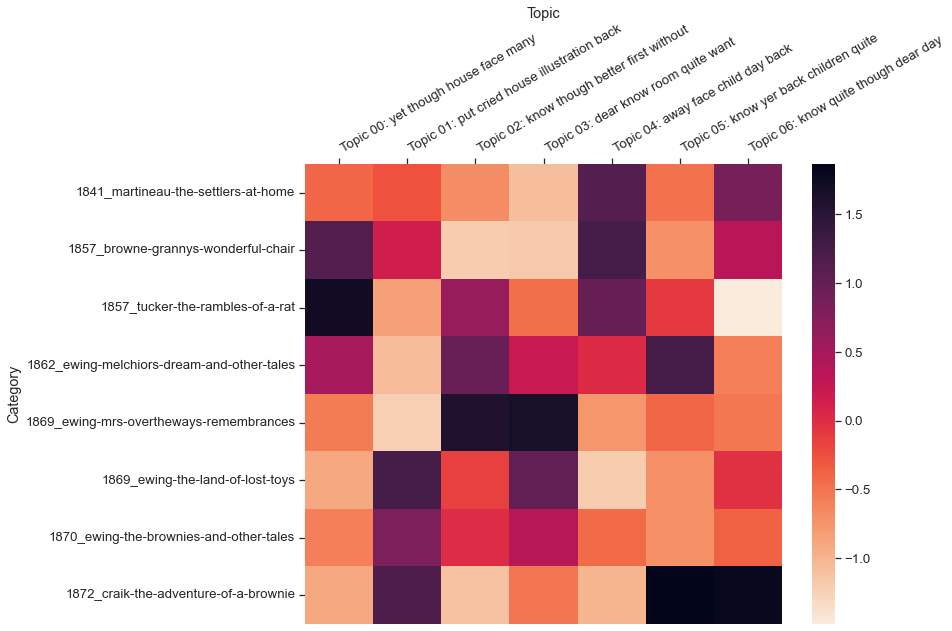

In [23]:
#FEMALE CORPUS
little_mallet_wrapper.plot_categories_by_topics_heatmap(f_book_titles,
                                      f_topic_distributions,
                                      f_topics, 
                                      f_output_directory_path + '/categories_by_topics.pdf',
                                      target_labels=f_target_labels,
                                      dim= (13, 9)
                                     )


The darker squares in this heatmap represent a high probability for the corresponding topic (compared to everyone else in the heatmap) and the lighter squares in the heatmap represent a low probability for the corresponding topic.

Here, we are plotting the data relative to *some* documents from the *male* corpus.

In [24]:
#MALE CORPUS

m_target_labels = ['1848_marryat-the-little-savage',
 '1851_ruskin-the-king-of-the-golden-river',
 '1857_ballantyne-the-coral-island-a-tale-of-the-pacific-ocean',
 '1857_hughes-tom-browns-school-days',
 '1862_farrar-st-winfreds-the-world-of-school',
 '1863_kingsley-the-water-babies',
 '1865_carroll-alices-adventures-in-wonderland',
 '1869_dickens-david-copperfield'
]

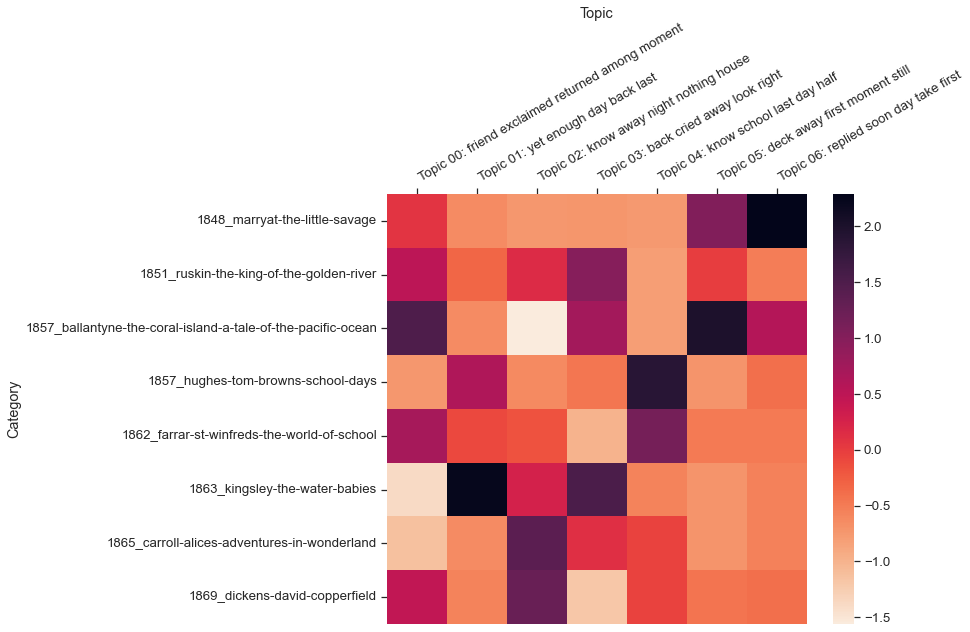

In [25]:
#MALE CORPUS
little_mallet_wrapper.plot_categories_by_topics_heatmap(m_book_titles,
                                      m_topic_distributions,
                                      m_topics, 
                                      m_output_directory_path + '/categories_by_topics.pdf',
                                      target_labels=m_target_labels,
                                      dim= (13, 9)
                                     )

## Display Top Titles Per Topic

We can also display the books that have the highest probability for every topic with the `little_mallet_wrapper.get_top_docs()` function.

To display only the title of the book, we'll first need to make two dictionaries for each corpus, which will allow us to find the corresponding book title and the original text from a given training document.

In [26]:
#MALE CORPUS
m_training_data_book_titles = dict(zip(m_training_data, m_book_titles))
m_training_data_original_text = dict(zip(m_training_data, m_original_texts))

#FEMALE CORPUS
f_training_data_book_titles = dict(zip(f_training_data, f_book_titles))
f_training_data_original_text = dict(zip(f_training_data, f_original_texts))

Then we'll use the function `display_top_titles_per_topic()` that will display the top text titles for a given topic, in the selected corpus (male/female). This function accepts a given `topic_number`, a desired `number_of_documents` to display, and the indication of the corpus we chose to analyse (set `corpus_gender` to either `"male"` or `"female"`)

In [27]:

def display_top_titles_per_topic(topic_number=0, number_of_documents=5, corpus_gender=str()):
    corpus_gender = corpus_gender.lower()
    if corpus_gender == "male":
        print(f"------------ ♂️ MALE CORPUS ------------\nTopic {topic_number}\n\n{m_topics[topic_number]}\n")

        for probability, document in little_mallet_wrapper.get_top_docs(m_training_data, m_topic_distributions, topic_number, n=number_of_documents):
            print(round(probability, 4), m_training_data_book_titles[document] + "\n")
        return
    elif corpus_gender == "female":
        print(f"------------ ♀️ FEMALE CORPUS ------------\nTopic {topic_number}\n\n{f_topics[topic_number]}\n")

        for probability, document in little_mallet_wrapper.get_top_docs(f_training_data, f_topic_distributions, topic_number, n=number_of_documents):
            print(round(probability, 4), f_training_data_book_titles[document] + "\n")
        return


In [28]:
display_top_titles_per_topic(topic_number=0, number_of_documents=5, corpus_gender="male")

------------ ♂️ MALE CORPUS ------------
Topic 0

['friend', 'exclaimed', 'returned', 'among', 'moment', 'thus', 'small', 'quite', 'also', 'many', 'became', 'day', 'friends', 'replied', 'first', 'almost', 'continued', 'surprise', 'found', 'river']

0.5897 1875_ballantyne-rivers-of-ice

0.5427 1886_ballantyne-the-prairie-chief

0.5214 1873_ballantyne-life-in-the-red-brigade

0.5144 1874_ballantyne-the-pirate-city-an-algerine-tale

0.4913 1856_ballantyne-the-young-fur-traders



In [29]:
display_top_titles_per_topic(topic_number=0, number_of_documents=5, corpus_gender="female")

------------ ♀️ FEMALE CORPUS ------------
Topic 0

['yet', 'though', 'house', 'face', 'many', 'even', 'day', 'know', 'whilst', 'life', 'forth', 'days', 'knew', 'moment', 'within', 'heart', 'spoke', 'fear', 'answered', 'back']

0.688 1906_everett_green-a-heroine-of-france-the-story-of-joan-of-arc

0.6607 1899_everett_green-french-and.english-a-story-of-the-struggle-in-america

0.6587 1898_everett_green-a-clerk-of-oxford-and-his-adventures-in-the-barons-war

0.6544 1893_everett_green-in-the-days-of-chivalry-a-tale-of-the-times-of-the-black-prince

0.6183 1892_everett_green-the-lord-of-dynevor-a-tale-of-the-times-of-edward-the-first



### Analysis of most relevant topics

After having analyzed the output topics, we try to identify those ones that seem to carry most interesting information for our analysis. 

From this standpoint, we identify the following topics as being the ones that carry potentially gender-related information:

<p align="center" style="color:red; font-weight:bold">
QUI SCEGLIAMO DEI TOPICS CHE VOGLIAMO ANALIZZARE E LI RENDIAMO ESPLICITI.
</p>


<span style="color:red; font-weight:bold">For example</span>, to display the top 3 book titles with the highest probability of containing topic 1 in the male corpus and topic 3 in the female corpus, we will run the `display_top_titles_per_topic()` function specifying the desired topics and corpus in input:

In [30]:
display_top_titles_per_topic(topic_number=1, number_of_documents=3, corpus_gender="male")
display_top_titles_per_topic(topic_number=3, number_of_documents=3, corpus_gender="female")


------------ ♂️ MALE CORPUS ------------
Topic 1

['yet', 'enough', 'day', 'back', 'last', 'even', 'night', 'life', 'stood', 'among', 'face', 'cried', 'knew', 'heart', 'word', 'many', 'every', 'still', 'fell', 'days']

0.5235 1889_reed-sir-ludar

0.5147 1855_kingsley-westward-ho

0.3656 1893_stevenson-catriona

------------ ♀️ FEMALE CORPUS ------------
Topic 3

['dear', 'know', 'room', 'quite', 'want', 'school', 'house', 'course', 'back', 'won', 'day', 'really', 'face', 'moment', 'put', 'take', 'sort', 'give', 'mean', 'look']

0.7426 1910_meade-the-school-queens

0.7016 1898_meade-a-bunch-of-cherries-a-story-of-cherry-court-school

0.6997 1897_meade-wild-kitty



In [31]:
# divide the labels for each document in 2 groups for each corpus, pre and post 1800

male_pre1800 = [book for book in m_book_titles if book[0:4] <= "1879"]
male_post1800 = [book for book in m_book_titles if book[0:4] > "1879"]
female_pre1800 = [book for book in f_book_titles if book[0:4] <= "1879"]
female_post1800 = [book for book in f_book_titles if book[0:4] > "1879"]



In [32]:
import csv

def create_data_csv(corpus_gender): #creates a csv file, according to the corpus specified in input, to easily retrieve data
    corpus_gender.lower

    document_labels = [] # list of strings, that are the books' titles
    topics = [] #list of lists of strings, length is number of topics
    distributions = [] #list of lists of numbers, length is number of documents
    
    if corpus_gender == "male":
        topics = m_topics 
        distributions = m_topic_distributions
        document_labels = m_book_titles
        csvfile = open('m_tabular_results.csv', 'w', newline='')
        
    elif corpus_gender == "female":
        topics = f_topics
        distributions = f_topic_distributions
        document_labels = f_book_titles
        csvfile = open('f_tabular_results.csv', 'w', newline='')

    fieldnames = ['book_index','book_title']
    for topic_number, topic_words in enumerate(topics):
        first_words = topic_words[:4]
        field = f"Topic {topic_number}: {first_words}"
        fieldnames.append(field)
    

    list_for_csv = []
    for row in distributions:
        row_to_add =[]
        position= distributions.index(row)
        row_to_add.append(position)
        row_to_add.append(document_labels[position])

        
        for prob in row:
            prob = round(prob, 4)
            row_to_add.append(prob)
        list_for_csv.append(row_to_add)
        
    writer = csv.writer(csvfile)

    writer.writerow(fieldnames)

    for row in list_for_csv:
            writer.writerow(row)
    csvfile.close()    


In [33]:
create_data_csv("male")
create_data_csv("female")
